<a href="https://colab.research.google.com/github/undefinedzero/SelfDrivingCar-Perception-Project/blob/master/Task1%262.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install detectron2 and download dataset

In [0]:
#mount google drive to access dataset
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#need to change the path of the dataset
!cp /content/drive/Shared\ drives/ROB535/rob535-fall-2019-task-1-image-classification.zip ./

In [0]:
!unzip /content/rob535-fall-2019-task-1-image-classification.zip

In [0]:
# install dependencies
!pip install -U torch torchvision cython
!pip install -U 'git+https://github.com/facebookresearch/fvcore.git' 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
torch.__version__
!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
!pip install -e detectron2_repo

In [0]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

# Visualize Data

/content/data-2019/test/d441b25e-dd7d-46c2-895d-2510bcbd207d/0055_image.jpg
[*] bbox not found.


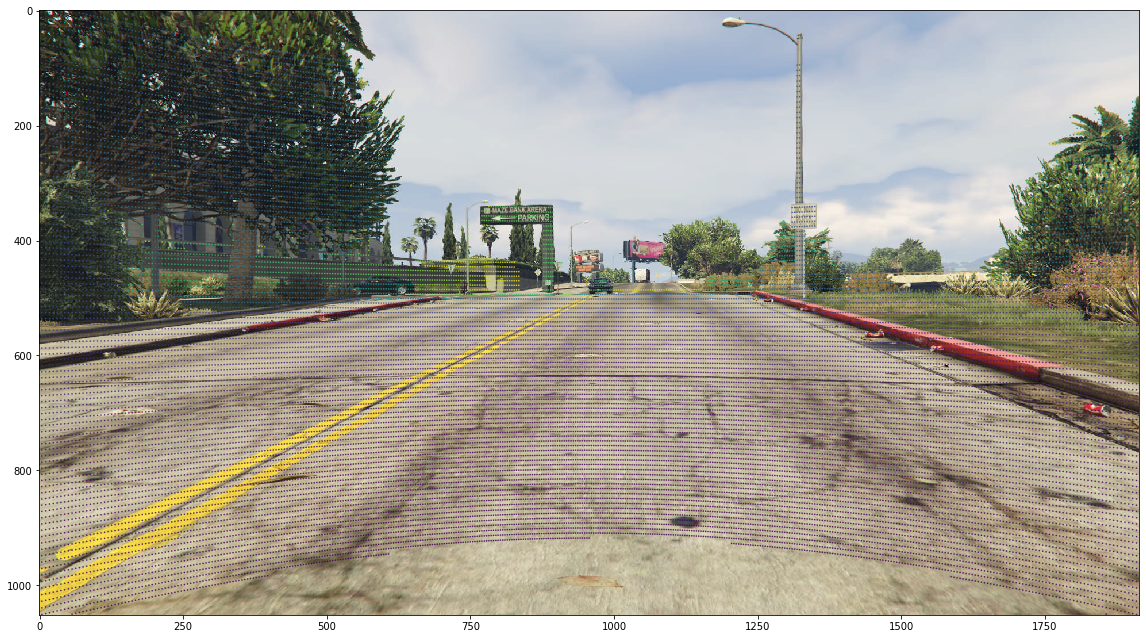

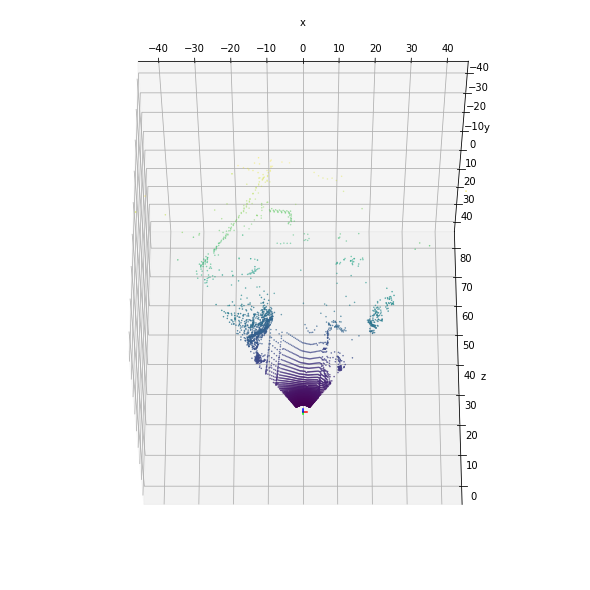

In [0]:
#! /usr/bin/python3
from glob import glob
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np


def rot(n):
    n = np.asarray(n).flatten()
    assert(n.size == 3)

    theta = np.linalg.norm(n)
    if theta:
        n /= theta
        K = np.array([[0, -n[2], n[1]], [n[2], 0, -n[0]], [-n[1], n[0], 0]])

        return np.identity(3) + np.sin(theta) * K + (1 - np.cos(theta)) * K @ K
    else:
        return np.identity(3)


def get_bbox(p0, p1):
    """
    Input:
    *   p0, p1
        (3)
        Corners of a bounding box represented in the body frame.

    Output:
    *   v
        (3, 8)
        Vertices of the bounding box represented in the body frame.
    *   e
        (2, 14)
        Edges of the bounding box. The first 2 edges indicate the `front` side
        of the box.
    """
    v = np.array([
        [p0[0], p0[0], p0[0], p0[0], p1[0], p1[0], p1[0], p1[0]],
        [p0[1], p0[1], p1[1], p1[1], p0[1], p0[1], p1[1], p1[1]],
        [p0[2], p1[2], p0[2], p1[2], p0[2], p1[2], p0[2], p1[2]]
    ])
    e = np.array([
        [2, 3, 0, 0, 3, 3, 0, 1, 2, 3, 4, 4, 7, 7],
        [7, 6, 1, 2, 1, 2, 4, 5, 6, 7, 5, 6, 5, 6]
    ], dtype=np.uint8)

    return v, e


classes = (
    'Unknown', 'Compacts', 'Sedans', 'SUVs', 'Coupes',
    'Muscle', 'SportsClassics', 'Sports', 'Super', 'Motorcycles',
    'OffRoad', 'Industrial', 'Utility', 'Vans', 'Cycles',
    'Boats', 'Helicopters', 'Planes', 'Service', 'Emergency',
    'Military', 'Commercial', 'Trains'
)

#files = glob('/content/drive/My Drive/rob535/data-2019/trainval/141e18e6-dd2f-429d-a89e-b2a3c17f25ff/0009_image.jpg')
files = glob('/content/data-2019/test/d441b25e-dd7d-46c2-895d-2510bcbd207d/0055_image.jpg')
# for idx in range(len(files)):
#idx = np.random.randint(0, len(files))
snapshot = files[0]
print(snapshot)

img = plt.imread(snapshot)

xyz = np.fromfile(snapshot.replace('_image.jpg', '_cloud.bin'), dtype=np.float32)
xyz = xyz.reshape([3, -1])

proj = np.fromfile(snapshot.replace('_image.jpg', '_proj.bin'), dtype=np.float32)
proj.resize([3, 4])

try:
    bbox = np.fromfile(snapshot.replace('_image.jpg', '_bbox.bin'), dtype=np.float32)
except FileNotFoundError:
    print('[*] bbox not found.')
    bbox = np.array([], dtype=np.float32)

bbox = bbox.reshape([-1, 11])

uv = proj @ np.vstack([xyz, np.ones_like(xyz[0, :])])
uv = uv / uv[2, :]

dist = np.linalg.norm(xyz, axis=0)
fig1 = plt.figure(1, figsize=(16, 9))
ax1 = fig1.add_subplot(1, 1, 1)
ax1.imshow(img)
ax1.scatter(uv[0, :], uv[1, :], c=dist, marker='.', s=1)
ax1.axis('scaled')
fig1.tight_layout()

fig2 = plt.figure(2, figsize=(8, 8))
ax2 = Axes3D(fig2)
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('z')

step = 5
ax2.scatter(
    xyz[0, ::step], xyz[1, ::step], xyz[2, ::step],
    c=dist[::step], marker='.', s=1
)

colors = ['C{:d}'.format(i) for i in range(10)]
for k, b in enumerate(bbox):
    R = rot(b[0:3])
    t = b[3:6]

    sz = b[6:9]
    vert_3D, edges = get_bbox(-sz / 2, sz / 2)
    vert_3D = R @ vert_3D + t[:, np.newaxis]

    vert_2D = proj @ np.vstack([vert_3D, np.ones(vert_3D.shape[1])])
    vert_2D = vert_2D / vert_2D[2, :]

    clr = colors[np.mod(k, len(colors))]
    for e in edges.T:
        ax1.plot(vert_2D[0, e], vert_2D[1, e], color=clr)
        ax2.plot(vert_3D[0, e], vert_3D[1, e], vert_3D[2, e], color=clr)

    c = classes[int(b[9])]
    ignore_in_eval = bool(b[10])
    if ignore_in_eval:
        ax2.text(t[0], t[1], t[2], c, color='r')
    else:
        ax2.text(t[0], t[1], t[2], c)

ax2.auto_scale_xyz([-40, 40], [-40, 40], [0, 80])
ax2.view_init(elev=-30, azim=-90)

for e in np.identity(3):
    ax2.plot([0, e[0]], [0, e[1]], [0, e[2]], color=e)

plt.show()


# Task 1

## using Pre-train model to detect

In [0]:
#! /usr/bin/python3
from glob import glob
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
files = glob('/content/data-2019/trainval/*/*.jpg')
guid_list=[]
label_list=[]
cfg = get_cfg()
cfg.merge_from_file("./detectron2_repo/configs/Misc/cascade_mask_rcnn_X_152_32x8d_FPN_IN5k_gn_dconv.yaml")
cfg.MODEL.WEIGHTS = "/content/drive/My Drive/rob535/model_0039999_e76410.pkl"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
predictor = DefaultPredictor(cfg)

import csv
path = "/content/labels.csv"
trainval_names=[]
trainval_labels={}
with open(path,'r') as f:
    csv_read = csv.reader(f)
    for row in csv_read:
      trainval_names.append('/content/data-2019/trainval/'+row[0]+'_image.jpg')
      trainval_labels['/content/data-2019/trainval/'+row[0]+'_image.jpg'] = row[1]

error=0
for snapshot in trainval_names[1:-1]:
  #snapshot = files[idx]
  print(snapshot)

  im = cv2.imread(snapshot)

  xyz = np.fromfile(snapshot.replace('_image.jpg', '_cloud.bin'), dtype=np.float32)
  xyz = xyz.reshape([3, -1])

  proj = np.fromfile(snapshot.replace('_image.jpg', '_proj.bin'), dtype=np.float32)
  proj.resize([3, 4])

  uv = proj @ np.vstack([xyz, np.ones_like(xyz[0, :])])
  uv = uv / uv[2, :]

  dist = np.linalg.norm(xyz, axis=0)

  outputs=predictor(im)

  bbx_trucks = outputs["instances"].pred_boxes[outputs["instances"].pred_classes == 7]
  bbx_buses = outputs["instances"].pred_boxes[outputs["instances"].pred_classes == 5]
  bbx_cars = outputs["instances"].pred_boxes[outputs["instances"].pred_classes == 2]
  bbx_motos = outputs["instances"].pred_boxes[outputs["instances"].pred_classes == 3]
  bbx_bikes = outputs["instances"].pred_boxes[outputs["instances"].pred_classes == 1]
  bbx_trains = outputs["instances"].pred_boxes[outputs["instances"].pred_classes == 6]

  bbx_trucks_arr=bbx_trucks.to("cpu").tensor.numpy()
  bbx_cars_arr=bbx_cars.to("cpu").tensor.numpy()
  bbx_motos_arr=bbx_motos.to("cpu").tensor.numpy()
  bbx_bikes_arr=bbx_bikes.to("cpu").tensor.numpy()
  bbx_buses_arr=bbx_buses.to("cpu").tensor.numpy()
  bbx_trains_arr=bbx_trains.to("cpu").tensor.numpy()

  uv_map = np.vstack([uv[0:2,:], dist])

  dist_idx_show=[]
  labels=[2,1,3,3,2,2]
  k=0
  for bbx_arr in [bbx_trucks_arr,bbx_cars_arr,bbx_motos_arr,bbx_bikes_arr,bbx_buses_arr,bbx_trains_arr]:
    for i in range(np.size(bbx_arr,0)):
      dist_idx=np.where(np.bitwise_and(
        np.bitwise_and(uv_map[0,:]>=bbx_arr[i,0], uv_map[1,:]>=bbx_arr[i,1]),
        np.bitwise_and(uv_map[0,:]<=bbx_arr[i,2], uv_map[1,:]<=bbx_arr[i,3]))==1)
      if np.sum(uv_map[2,dist_idx]):
        dist_temp = np.median(uv_map[2,dist_idx])
        if dist_temp < 50:
          dist_idx_show.append(dist_idx)
          label_test = labels[k]
          print(labels[k])
    k=k+1

  if not dist_idx_show:
    label_test = 0
    print(0)
  if len(dist_idx_show) > 1:
    print("!!!!!!!!!")
    print(snapshot)
    print('!!!!!!!!!bad label')
  if label_test != int(trainval_labels[snapshot]):
    print('error!!!!')
    error=error+1

  a = snapshot.replace('_image.jpg', '')
  b = a.replace('/content/data-2019/test/', '')
  guid_list.append(b)
  label_list.append(label_test)

## inspect single image output
different models and image enhancement

In [0]:
#! /usr/bin/python3
from glob import glob
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

def hisEqulColor(img):
    ycrcb = cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB)
    channels = cv2.split(ycrcb)
    cv2.equalizeHist(channels[0], channels[0])
    cv2.merge(channels, ycrcb)
    cv2.cvtColor(ycrcb, cv2.COLOR_YCR_CB2BGR, img)
    return img

#files = glob('/content/drive/My Drive/rob535/data-2019/trainval/e6fd2c25-31a1-49f5-8e70-63db026d51a0/0035_image.jpg')
files = glob('/content/data-2019/test/5d07a8d5-1fed-47ef-8bb7-a6074763e09e/0003_image.jpg')
#files = glob('/content/data-2019/trainval/03efdd60-a7f4-4e03-8723-6f4bf6c1f276/0001_image.jpg')
guid_list=[]
label_list=[]
cfg = get_cfg()
cfg.merge_from_file("./detectron2_repo/configs/Misc/cascade_mask_rcnn_X_152_32x8d_FPN_IN5k_gn_dconv.yaml")
#cfg.merge_from_file("/content/detectron2_repo/configs/Cityscapes/mask_rcnn_R_50_FPN.yaml")
cfg.MODEL.WEIGHTS = "/content/drive/My Drive/rob535/model_0039999_e76410.pkl"
#cfg.MODEL.WEIGHTS = "/content/model_final_af9cf5.pkl"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
predictor = DefaultPredictor(cfg)

snapshot = files[0]
print(snapshot)

im = cv2.imread(snapshot)

xyz = np.fromfile(snapshot.replace('_image.jpg', '_cloud.bin'), dtype=np.float32)
xyz = xyz.reshape([3, -1])

proj = np.fromfile(snapshot.replace('_image.jpg', '_proj.bin'), dtype=np.float32)
proj.resize([3, 4])

uv = proj @ np.vstack([xyz, np.ones_like(xyz[0, :])])
uv = uv / uv[2, :]

dist = np.linalg.norm(xyz, axis=0)

# Image Enhancement for Night
'''
mn=im.shape[0:3]
uvimg=np.zeros(mn)
ruv=np.round(uv)
ndist=max(dist)
for i in range(len(dist)):
  uvimg[int(ruv[1,i]), int(ruv[0,i]),0]=int(255*(1-dist[i]/ndist))
  uvimg[int(ruv[1,i]), int(ruv[0,i]),1]=int(255*(1-dist[i]/ndist))
  uvimg[int(ruv[1,i]), int(ruv[0,i]),2]=int(255*(1-dist[i]/ndist))

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (6,11))
img_dilation = cv2.dilate(uvimg, kernel, iterations=1) 
edges = cv2.Canny(np.uint8(img_dilation),100,200)
edgesimg=np.zeros(mn)
edgesimg[:,:,0]=edges
edgesimg[:,:,1]=edges
edgesimg[:,:,2]=edges

kernel = np.ones((3,3), np.uint8) 
img_edge = cv2.dilate(edgesimg, kernel, iterations=1)
im = np.uint8(np.clip((1+img_edge/255)*im + img_dilation/5, 0, 255))
'''

#Equalize Histogram (BAD!)
'''
for i in range(3):
  im[:,:,i]=np.uint8(cv2.equalizeHist(im[:,:,i]))
'''

outputs=predictor(im)

bbx_trucks = outputs["instances"].pred_boxes[outputs["instances"].pred_classes == 7]
bbx_buses = outputs["instances"].pred_boxes[outputs["instances"].pred_classes == 5]
bbx_cars = outputs["instances"].pred_boxes[outputs["instances"].pred_classes == 2]
bbx_motos = outputs["instances"].pred_boxes[outputs["instances"].pred_classes == 3]
bbx_bikes = outputs["instances"].pred_boxes[outputs["instances"].pred_classes == 1]
bbx_trains = outputs["instances"].pred_boxes[outputs["instances"].pred_classes == 6]

bbx_trucks_arr=bbx_trucks.to("cpu").tensor.numpy()
bbx_cars_arr=bbx_cars.to("cpu").tensor.numpy()
bbx_motos_arr=bbx_motos.to("cpu").tensor.numpy()
bbx_bikes_arr=bbx_bikes.to("cpu").tensor.numpy()
bbx_buses_arr=bbx_buses.to("cpu").tensor.numpy()
bbx_trains_arr=bbx_trains.to("cpu").tensor.numpy()

uv_map = np.vstack([uv[0:2,:], dist])

dist_idx_show=[]
labels=[2,1,3,3,2,2]
k=0
for bbx_arr in [bbx_trucks_arr,bbx_cars_arr,bbx_motos_arr,bbx_bikes_arr,bbx_buses_arr,bbx_trains_arr]:
  for i in range(np.size(bbx_arr,0)):
    dist_idx=np.where(np.bitwise_and(
      np.bitwise_and(uv_map[0,:]>=bbx_arr[i,0], uv_map[1,:]>=bbx_arr[i,1]),
      np.bitwise_and(uv_map[0,:]<=bbx_arr[i,2], uv_map[1,:]<=bbx_arr[i,3]))==1)
    if np.sum(uv_map[2,dist_idx]):
      if np.median(uv_map[2,dist_idx]) < 50:
        dist_idx_show.append(dist_idx)
        label_test = labels[k]
        print(labels[k])
  k=k+1

if not dist_idx_show:
  label_test = 0
  print(0)
if len(dist_idx_show) > 1:
  print("!!!!!!!!!")
  print(snapshot)
  print('!!!!!!!!!bad label')

v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])

In [0]:
im2=cv2.imread('/content/drive/My Drive/rob535/data-2019/trainval/01aaa345-52ad-4939-8207-2d39c11acfdc/0017_image.jpg')
sum(sum(im2[:,:,1]<50))/(np.size(im2))*3

Instances(num_instances=3, image_height=1052, image_width=1914, fields=[pred_boxes = Boxes(tensor([[ 543.0677,  461.5910,  654.3661,  496.3557],
        [ 955.6683,  466.7216,  998.6913,  494.0417],
        [1815.3630,  679.8524, 1865.7057,  707.7893]], device='cuda:0')), scores = tensor([0.9894, 0.9433, 0.5193], device='cuda:0'), pred_classes = tensor([2, 2, 2], device='cuda:0'), pred_masks = tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False

## try to fix multi-object cases(TODO!)

In [0]:
#! /usr/bin/python3
from glob import glob
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
#files = glob('/content/drive/My Drive/rob535/data-2019/trainval/01aaa345-52ad-4939-8207-2d39c11acfdc/0005_image.jpg')
#files = glob('/content/drive/My Drive/rob535/data-2019/test/030a2430-5503-47c8-87df-8df226c188b2/0056_image.jpg')
files = glob('/content/data-2019/trainval/02a0f3cc-dc81-417d-a9fd-b6066711c610/0009_image.jpg')
guid_list=[]
label_list=[]
cfg = get_cfg()
cfg.merge_from_file("./detectron2_repo/configs/Misc/cascade_mask_rcnn_X_152_32x8d_FPN_IN5k_gn_dconv.yaml")
cfg.MODEL.WEIGHTS = "/content/drive/My Drive/rob535/model_0039999_e76410.pkl"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
predictor = DefaultPredictor(cfg)

error=0
snapshot = files[0]
print(snapshot)

im = cv2.imread(snapshot)

xyz = np.fromfile(snapshot.replace('_image.jpg', '_cloud.bin'), dtype=np.float32)
xyz = xyz.reshape([3, -1])

proj = np.fromfile(snapshot.replace('_image.jpg', '_proj.bin'), dtype=np.float32)
proj.resize([3, 4])

uv = proj @ np.vstack([xyz, np.ones_like(xyz[0, :])])
uv = uv / uv[2, :]

dist = np.linalg.norm(xyz, axis=0)

outputs=predictor(im)

bboxes_arr=outputs["instances"].pred_boxes.to("cpu").tensor.numpy()
bboxes_class=outputs["instances"].pred_classes.to("cpu").numpy()
bboxes_scores=outputs["instances"].scores.to("cpu").numpy()

uv_map = np.vstack([uv[0:2,:], dist])

labels=np.zeros(91)
labels[[7,5,2,3,1,6]]=[2,1,3,3,2,2]
valid_bbx_arr=[]
valid_bbx_dist=[]
valid_bbx_class=[]
valid_bbx_score=[]
for idx in len(bboxes_arr):
  bbx_arr=bboxes_arr[idx]
  bbx_score=bboxes_scores[idx]
  bbx_class=labels[bboxes_class[idx]]
  for i in range(np.size(bbx_arr,0)):
    dist_idx=np.where(np.bitwise_and(
      np.bitwise_and(uv_map[0,:]>=bbx_arr[i,0], uv_map[1,:]>=bbx_arr[i,1]),
      np.bitwise_and(uv_map[0,:]<=bbx_arr[i,2], uv_map[1,:]<=bbx_arr[i,3]))==1)
    bbx_dist = np.median(uv_map[2,dist_idx])
    if bbx_dist < 50:
      valid_bbx_arr.append(bbx_arr)
      valid_bbx_dist.append(bbx_dist)
      valid_bbx_class.append(bbx_class)
      valid_bbx_score.append(bbx_score)

if not valid_bbx_arr:
  label_test = 0
  print(0)
else:
  

if label_test != int(trainval_labels[snapshot]):
  print('error!!!!')
  error=error+1

v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])

## write task1 csv

In [0]:
[guid_list[1], label_list[1]]

['0213ada8-e776-4404-9312-c264153c57c1/0001', 2]

In [0]:
import csv
path = "/content/drive/My Drive/rob535/test3.csv"
with open(path,'w') as f:
    csv_write = csv.writer(f)
    csv_head = ["guid/image","label"]
    csv_write.writerow(csv_head)
    for i in range(1799):
      b = guid_list[i].replace('/content/data-2019/test/', '')
      csv_data = [b,str(label_list[i])]
      csv_write.writerow(csv_data)

In [0]:
import csv
path = "/content/labels.csv"
trainval_names=[]
trainval_labels={}
with open(path,'r') as f:
    csv_read = csv.reader(f)
    for row in csv_read:
      trainval_names.append('/content/data-2019/trainval/'+row[0]+'_image.jpg')
      trainval_labels['/content/data-2019/trainval/'+row[0]+'_image.jpg'] = row[1]

'1'

# Using Given Data to Finetune

## prepare training dataset

In [0]:
#! /usr/bin/python3
from glob import glob
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np


def rot(n):
    n = np.asarray(n).flatten()
    assert(n.size == 3)

    theta = np.linalg.norm(n)
    if theta:
        n /= theta
        K = np.array([[0, -n[2], n[1]], [n[2], 0, -n[0]], [-n[1], n[0], 0]])

        return np.identity(3) + np.sin(theta) * K + (1 - np.cos(theta)) * K @ K
    else:
        return np.identity(3)


def get_bbox(p0, p1):
    """
    Input:
    *   p0, p1
        (3)
        Corners of a bounding box represented in the body frame.

    Output:
    *   v
        (3, 8)
        Vertices of the bounding box represented in the body frame.
    *   e
        (2, 14)
        Edges of the bounding box. The first 2 edges indicate the `front` side
        of the box.
    """
    v = np.array([
        [p0[0], p0[0], p0[0], p0[0], p1[0], p1[0], p1[0], p1[0]],
        [p0[1], p0[1], p1[1], p1[1], p0[1], p0[1], p1[1], p1[1]],
        [p0[2], p1[2], p0[2], p1[2], p0[2], p1[2], p0[2], p1[2]]
    ])
    e = np.array([
        [2, 3, 0, 0, 3, 3, 0, 1, 2, 3, 4, 4, 7, 7],
        [7, 6, 1, 2, 1, 2, 4, 5, 6, 7, 5, 6, 5, 6]
    ], dtype=np.uint8)

    return v, e


classes = (
    'Unknown', 'Compacts', 'Sedans', 'SUVs', 'Coupes',
    'Muscle', 'SportsClassics', 'Sports', 'Super', 'Motorcycles',
    'OffRoad', 'Industrial', 'Utility', 'Vans', 'Cycles',
    'Boats', 'Helicopters', 'Planes', 'Service', 'Emergency',
    'Military', 'Commercial', 'Trains'
)
classes_new = (0,1,1,1,1,1,1,1,1,3,3,2,2,2,3,0,0,0,2,2,2,2,0)
class2coco = (0,2,7,3)
import csv
path = "/content/labels.csv"
image_names=[]
image_labels=[]
total_annos={}
with open(path,'r') as f:
  csv_read = csv.reader(f)
  for row in csv_read:
    image_names.append('/content/data-2019/trainval/'+row[0]+'_image.jpg')
    image_labels.append(row[1])
for i in range(1,len(image_names)):
  snapshot = image_names[i]

  proj = np.fromfile(snapshot.replace('_image.jpg', '_proj.bin'), dtype=np.float32)
  proj.resize([3, 4])

  try:
      bbox = np.fromfile(snapshot.replace('_image.jpg', '_bbox.bin'), dtype=np.float32)
  except FileNotFoundError:
      print('[*] bbox not found.')
      bbox = np.array([], dtype=np.float32)

  bbox = bbox.reshape([-1, 11])

  bbxs = []
  for k, b in enumerate(bbox):
      R = rot(b[0:3])
      t = b[3:6]

      sz = b[6:9]
      vert_3D, edges = get_bbox(-sz / 2, sz / 2)
      vert_3D = R @ vert_3D + t[:, np.newaxis]
      vert_2D = proj @ np.vstack([vert_3D, np.ones(vert_3D.shape[1])])
      vert_2D = vert_2D / vert_2D[2, :]
      c = classes_new[int(b[9])]
      ignore_in_eval = bool(b[10])
      if not ignore_in_eval:
        bbx = [min(vert_2D[0,:]),min(vert_2D[1,:]),max(vert_2D[0,:]),max(vert_2D[1,:]),class2coco[c]]
        bbxs.append(bbx)
  total_annos[snapshot]=bbxs
  print(100*i/len(image_names))

## write training annotations to file

In [0]:
import os
import json
import numpy as np
import pandas as pd
import glob
import cv2
import os
import shutil
from IPython import embed
from sklearn.model_selection import train_test_split
classname_to_id = {"car": 2, "truck":7, "motos":3}

class Csv2CoCo:

    def __init__(self,image_dir,total_annos):
        self.images = []
        self.annotations = []
        self.categories = []
        self.img_id = 0
        self.ann_id = 0
        self.image_dir = image_dir
        self.total_annos = total_annos

    def save_coco_json(self, instance, save_path):
        json.dump(instance, open(save_path, 'w'), ensure_ascii=False, indent=2)  # indent=2 更加美观显示

    # 由txt文件构建COCO
    def to_coco(self, keys):
        self._init_categories()
        for key in keys:
            self.images.append(self._image(key))
            self.img_id += 1
        instance = {}
        instance['info'] = 'Jianing Created'
        instance['license'] = ['license']
        instance['images'] = self.images
        return instance

    # 构建类别
    def _init_categories(self):
        for k, v in classname_to_id.items():
            category = {}
            category['id'] = v
            category['name'] = k
            self.categories.append(category)

    # 构建COCO的image字段
    def _image(self, path):
        image = {}
        print(path)
        img = cv2.imread(path)
        image['height'] = img.shape[0]
        image['width'] = img.shape[1]
        image['id'] = self.img_id
        image['file_name'] = path
        shapes = self.total_annos[path]
        self.annotations=[]
        for shape in shapes:
            bboxi = []
            for cor in shape[:-1]:
                bboxi.append(int(cor))
            label = shape[-1]
            bboxi[0]=max(0,bboxi[0])
            bboxi[1]=max(0,bboxi[1])
            bboxi[2]=min(1914,bboxi[2])
            bboxi[3]=min(1052,bboxi[3])
            if(label==2 and min(bboxi)>0):
              annotation = self._annotation(bboxi,label)
              self.annotations.append(annotation)
              self.ann_id += 1
        image['annotations'] = self.annotations
        return image

    # 构建COCO的annotation字段
    def _annotation(self, shape,label):
        # label = shape[-1]
        points = shape[:4]
        annotation = {}
        annotation['id'] = self.ann_id
        annotation['image_id'] = self.img_id
        annotation['category_id'] = int(label)
        annotation['segmentation'] = self._get_seg(points)
        annotation['bbox'] = self._get_box(points)
        annotation['iscrowd'] = 0
        annotation['area'] = self._get_area(points)
        return annotation

    # COCO的格式： [x1,y1,w,h] 对应COCO的bbox格式
    def _get_box(self, points):
        min_x = points[0]
        min_y = points[1]
        max_x = points[2]
        max_y = points[3]
        return [min_x, min_y, max_x, max_y]
    # 计算面积
    def _get_area(self, points):
        min_x = points[0]
        min_y = points[1]
        max_x = points[2]
        max_y = points[3]
        return (max_x - min_x+1) * (max_y - min_y+1)
    # segmentation
    def _get_seg(self, points):
        min_x = points[0]
        min_y = points[1]
        max_x = points[2]
        max_y = points[3]
        h = max_y - min_y
        w = max_x - min_x
        a = []
        a.append([min_x,min_y, min_x,min_y+0.5*h, min_x,max_y, min_x+0.5*w,max_y, max_x,max_y, max_x,max_y-0.5*h, max_x,min_y, max_x-0.5*w,min_y])
        return a

if __name__ == '__main__':
    # 把训练集转化为COCO的json格式
    l2c_train = Csv2CoCo(image_dir="./",total_annos=total_annos)
    train_instance = l2c_train.to_coco(image_names[1:3000])
    l2c_train.save_coco_json(train_instance, '/content/data-2019/trainval/via_region_data.json')

## definie get_dicts function for loading dataset

In [0]:
import os
import numpy as np
import json
from detectron2.structures import BoxMode
import itertools

# write a function that loads the dataset into detectron2's standard format
def get_car_dicts(img_dir):
    json_file = os.path.join(img_dir, "via_region_data.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)

    dataset_dicts = []
    imgs_anns=imgs_anns["images"]
    for v in imgs_anns:
        record = {}
        
        filename = v["file_name"]
        height, width = cv2.imread(filename).shape[:2]
        
        record["file_name"] = filename
        record["image_id"] = v["id"]
        record["height"] = height
        record["width"] = width
      
        annos = v["annotations"]
        objs = []
        for anno in annos:
            obj = {
                "bbox": anno["bbox"],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": anno["segmentation"],
                "category_id": 0,
                "iscrowd": 0,
                "id": anno["id"]
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

## load dataset

In [0]:
from detectron2.data import DatasetCatalog, MetadataCatalog
DatasetCatalog.clear()
for d in ["train"]:
    DatasetCatalog.register("truck_" + d, lambda d=d: get_car_dicts("/content/data-2019/trainval/"))
    MetadataCatalog.get("truck_train").set(thing_classes=["truck"])
truck_metadata = MetadataCatalog.get("truck_train")

## inspect loaded data

In [0]:
dataset_dicts = get_car_dicts("/content/data-2019/trainval/")
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    print(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=truck_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

## train！

In [0]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file("./detectron2_repo/configs/Misc/cascade_mask_rcnn_X_152_32x8d_FPN_IN5k_gn_dconv.yaml")
cfg.MODEL.WEIGHTS = "/content/drive/My Drive/rob535/model_0039999_e76410.pkl"
cfg.DATASETS.TRAIN = ("truck_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough, but you can certainly train longer
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

## evaluate

In [0]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.DATASETS.TEST = ("truck_train", )
predictor = DefaultPredictor(cfg)

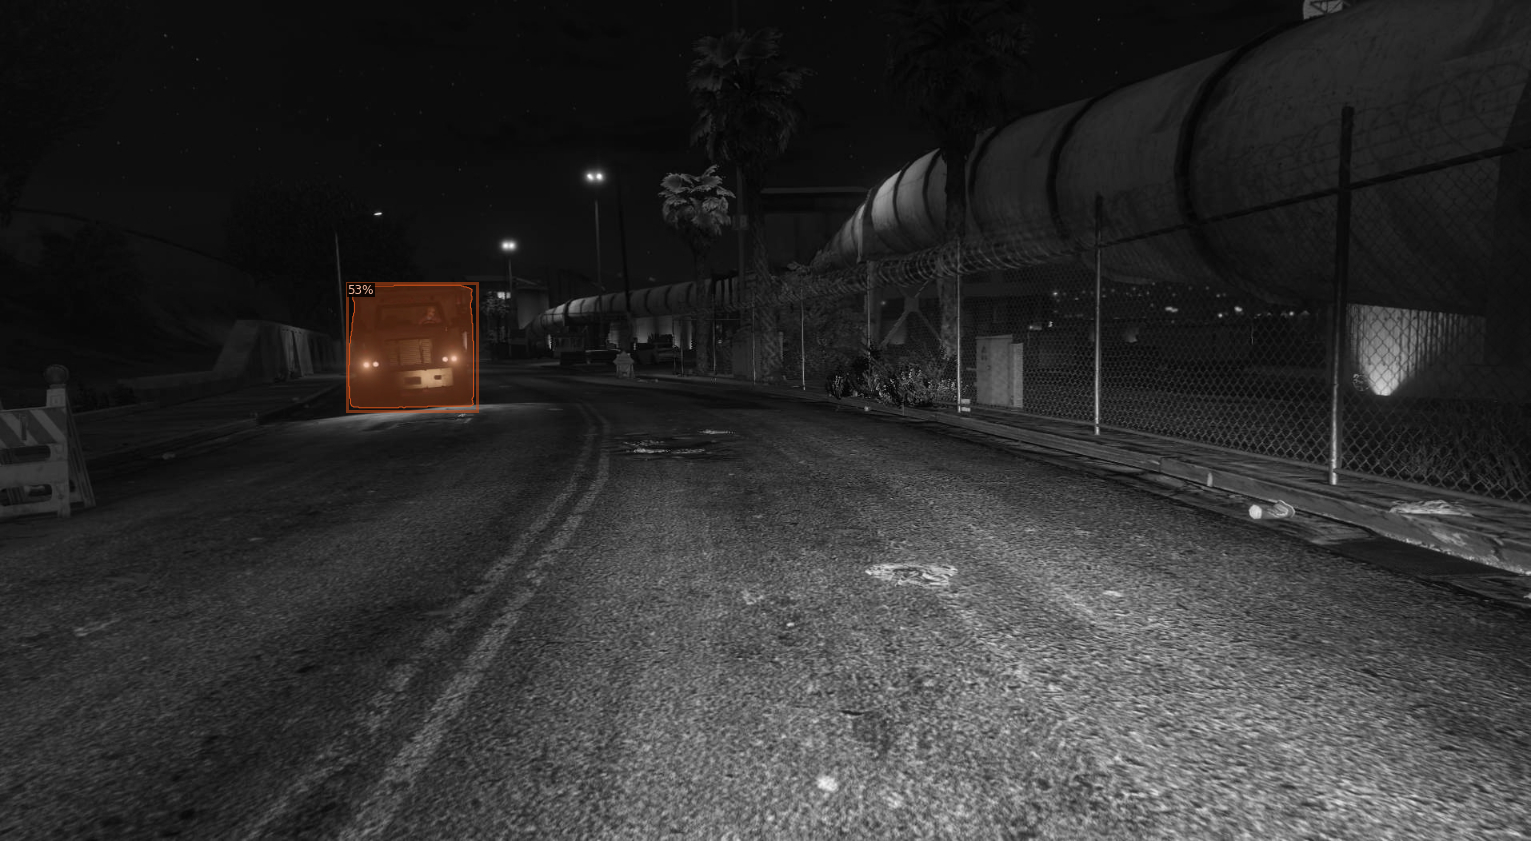

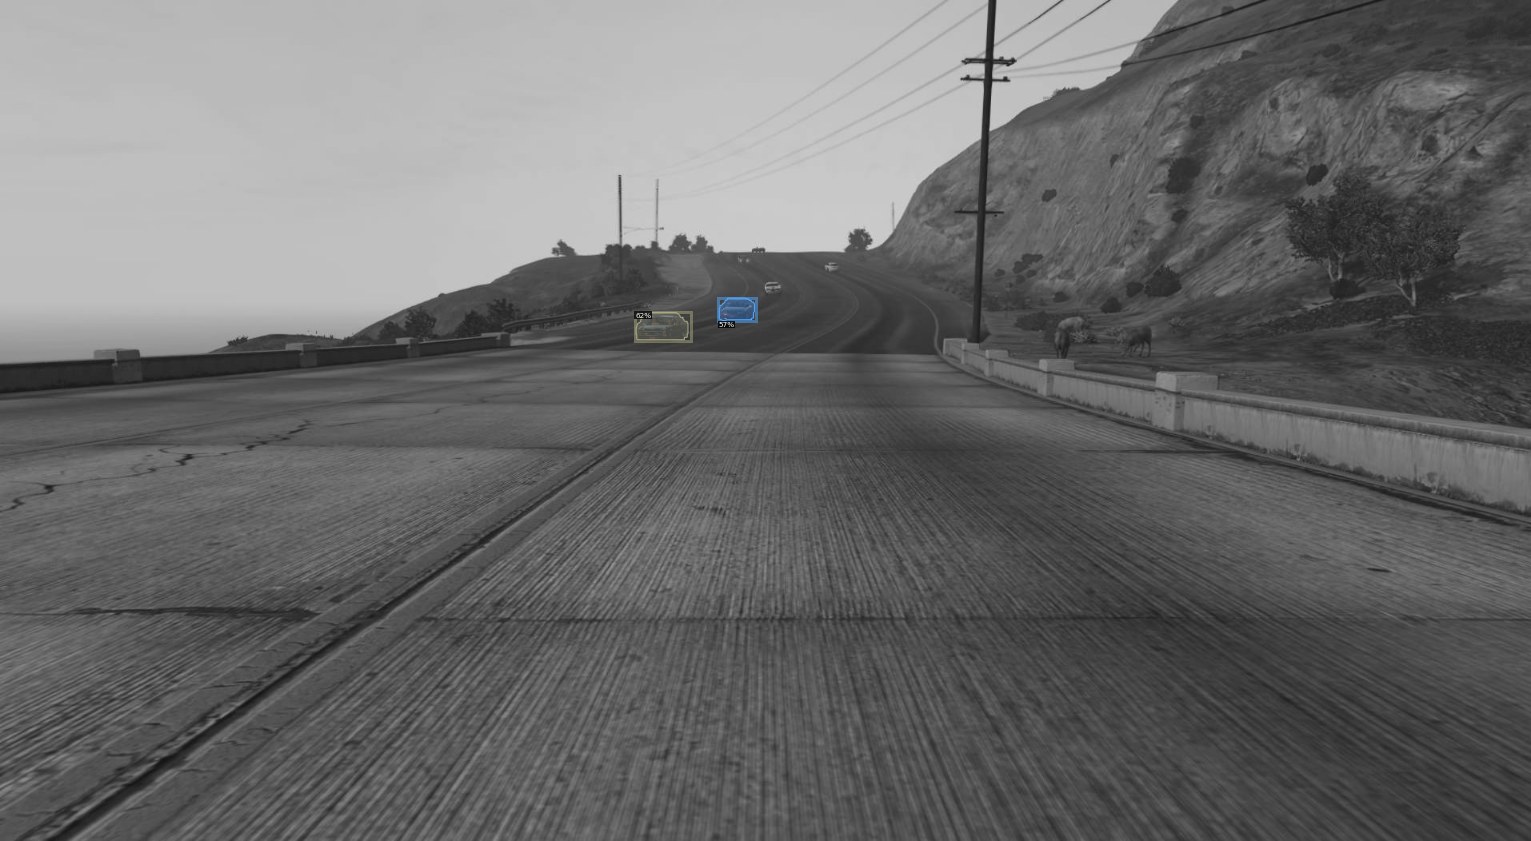

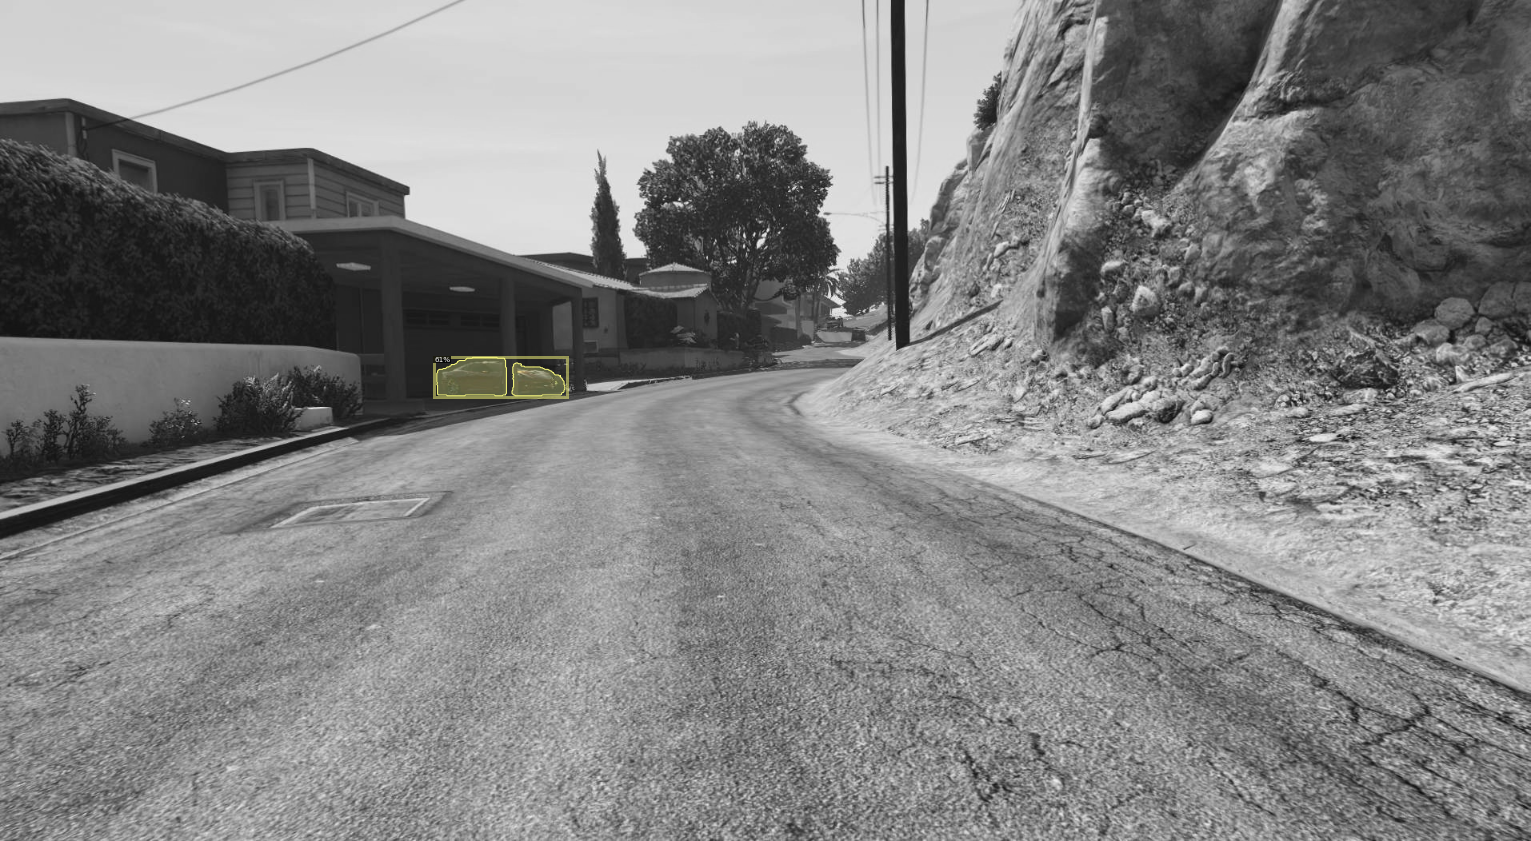

In [0]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_car_dicts("/content/data-2019/trainval/")
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=truck_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

In [0]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("truck_train", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "truck_train")
inference_on_dataset(trainer.model, val_loader, evaluator)
# another equivalent way is to use trainer.test

# Task 2

## using models to predict bbox
set high threshold at first, there might be many empty r/theta, then set lower threshold and run this cell again to predict them.

In [0]:
r_list={}
theta_list={}

In [0]:
#! /usr/bin/python3
from glob import glob
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import math

cfg = get_cfg()
cfg.merge_from_file("./detectron2_repo/configs/Misc/cascade_mask_rcnn_X_152_32x8d_FPN_IN5k_gn_dconv.yaml")
cfg.MODEL.WEIGHTS = "/content/drive/My Drive/rob535/model_0039999_e76410.pkl"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  #High 0.7
predictor = DefaultPredictor(cfg)

import csv
path = "/content/drive/My Drive/rob535/template.csv"
test_names=[]
trainval_labels={}
with open(path,'r') as f:
    csv_read = csv.reader(f)
    for row in csv_read:
      if row[0].replace('/r', '')!=row[0]:
        test_names.append('/content/data-2019/test/'+row[0].replace('/r', '')+'_image.jpg')

for snapshot in test_names:
  if r_list_save[snapshot]!=0:
    print('skip!')
    continue
  print(snapshot)

  im = cv2.imread(snapshot)

  xyz = np.fromfile(snapshot.replace('_image.jpg', '_cloud.bin'), dtype=np.float32)
  xyz = xyz.reshape([3, -1])

  proj = np.fromfile(snapshot.replace('_image.jpg', '_proj.bin'), dtype=np.float32)
  proj.resize([3, 4])

  uv = proj @ np.vstack([xyz, np.ones_like(xyz[0, :])])
  dist = np.linalg.norm(xyz, axis=0)
  real_uv_map = np.vstack([uv[0:3,:], dist])
  proj_inv = np.linalg.pinv(proj)
  uv = uv / uv[2, :]

  outputs=predictor(im)

  bbx_trucks = outputs["instances"].pred_boxes[outputs["instances"].pred_classes == 7]
  bbx_buses = outputs["instances"].pred_boxes[outputs["instances"].pred_classes == 5]
  bbx_cars = outputs["instances"].pred_boxes[outputs["instances"].pred_classes == 2]
  bbx_motos = outputs["instances"].pred_boxes[outputs["instances"].pred_classes == 3]
  bbx_bikes = outputs["instances"].pred_boxes[outputs["instances"].pred_classes == 1]
  bbx_trains = outputs["instances"].pred_boxes[outputs["instances"].pred_classes == 6]

  bbx_trucks_arr=bbx_trucks.to("cpu").tensor.numpy()
  bbx_cars_arr=bbx_cars.to("cpu").tensor.numpy()
  bbx_motos_arr=bbx_motos.to("cpu").tensor.numpy()
  bbx_bikes_arr=bbx_bikes.to("cpu").tensor.numpy()
  bbx_buses_arr=bbx_buses.to("cpu").tensor.numpy()
  bbx_trains_arr=bbx_trains.to("cpu").tensor.numpy()

  uv_map = np.vstack([uv[0:2,:], dist])

  dist_idx_show=[]
  min_dist=100
  labels=[2,1,3,3,2,2]
  k=0
  r=0
  theta=0
  for bbx_arr in [bbx_trucks_arr,bbx_cars_arr,bbx_motos_arr,bbx_bikes_arr,bbx_buses_arr,bbx_trains_arr]:
    for i in range(np.size(bbx_arr,0)):
      dist_idx=np.where(np.bitwise_and(
        np.bitwise_and(uv_map[0,:]>=bbx_arr[i,0], uv_map[1,:]>=bbx_arr[i,1]),
        np.bitwise_and(uv_map[0,:]<=bbx_arr[i,2], uv_map[1,:]<=bbx_arr[i,3]))==1)
      dist_idx=np.array(dist_idx[0])
      
      if np.sum(uv_map[2,dist_idx]):
        dist_temp = np.median(uv_map[2,dist_idx])
        area_dist=np.sqrt((bbx_arr[i,2]-bbx_arr[i,0])*(bbx_arr[i,3]-bbx_arr[i,1]))*dist_temp
        #print(dist_temp)
        #print(area_dist)
        if dist_temp < 60:  #High dist_temp < 60 and area_dist > 1700
          if min_dist>=dist_temp:
            min_dist=dist_temp
            xyz_box = xyz[:,dist_idx]
            l=xyz_box.shape[1]
            xyz_box_valid_idx = np.argsort(xyz_box[2,:])[int(l*0.15):int(l*0.7)]
            if max(xyz_box[2,xyz_box_valid_idx])-min(xyz_box[2,xyz_box_valid_idx]) < 2:
              r=np.sqrt(np.mean(xyz_box[0,xyz_box_valid_idx])**2+np.mean(xyz_box[1,xyz_box_valid_idx])**2+np.mean(xyz_box[2,xyz_box_valid_idx])**2)
              theta=math.atan(np.mean(xyz_box[0,xyz_box_valid_idx])/(np.mean(xyz_box[2,xyz_box_valid_idx])))/math.pi*180
            else:
              r=np.sqrt(np.mean(xyz_box[0,xyz_box_valid_idx])**2+np.mean(xyz_box[1,xyz_box_valid_idx])**2+np.mean(xyz_box[2,xyz_box_valid_idx])**2)
              theta=math.atan(np.mean(xyz_box[0,xyz_box_valid_idx])/(np.mean(xyz_box[2,xyz_box_valid_idx])))/math.pi*180
            dist_idx_show=dist_idx
            print(r)
            print(theta)
    k=k+1

  r_list[snapshot]=r
  theta_list[snapshot]=theta


#v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
#v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
#cv2_imshow(v.get_image()[:, :, ::-1])

## inspect single output

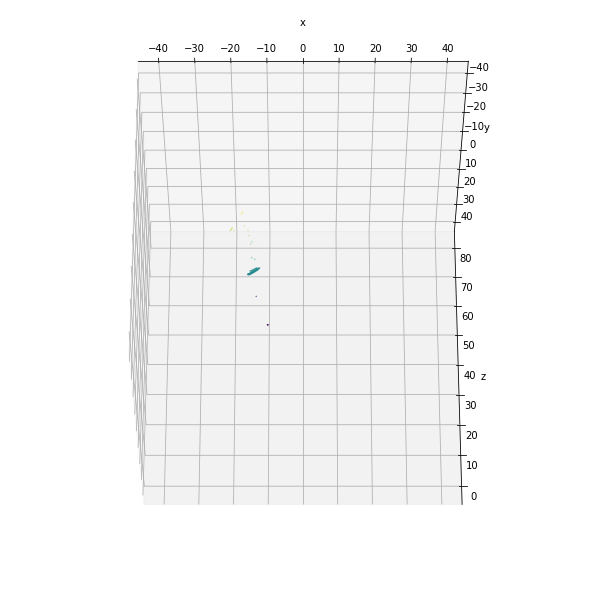

In [0]:
fig2 = plt.figure(2, figsize=(8, 8))
ax2 = Axes3D(fig2)
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('z')

step = 1
ax2.scatter(
    xyz_box[0, :], xyz_box[1, :], xyz_box[2, :],
    c=dist[dist_idx_show], marker='.', s=1
)
ax2.auto_scale_xyz([-40, 40], [-40, 40], [0, 80])
ax2.view_init(elev=-30, azim=-90)
plt.show()

##write task2 csv

In [0]:
import csv
path = "/content/drive/My Drive/rob535/test_task2_2.csv"
with open(path,'w') as f:
    csv_write = csv.writer(f)
    csv_head = ["guid/image/axis","value"]
    csv_write.writerow(csv_head)
    for i in range(800):
      a = test_names[i].replace('/content/data-2019/test/', '').replace('_image.jpg', '/r')
      csv_data_r = [a,str(r_list[test_names[i]])]
      csv_write.writerow(csv_data_r)
      b = test_names[i].replace('/content/data-2019/test/', '').replace('_image.jpg', '/theta')
      csv_data_theta = [b,str(theta_list[test_names[i]])]
      csv_write.writerow(csv_data_theta)

In [1]:
'''
asdasd
'''

'\nasdasd\n'